In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
# import projx as px
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams['figure.figsize'] = (12, 7)

In [4]:
def prob_dist(itrbl):
    count = {}
    for i in itrbl:
        count.setdefault(i, 0)
        count[i] += 1
    sr = pd.Series(count)
    prob = sr.apply(lambda x: float(x) / len(itrbl))
    return prob

def basic_graph_stats(g):
    stats = {
        "num_nodes": len(g),
        "num_edges": len(g.edges()),
        "density": nx.density(g),
        "diameter": nx.diameter(g),
        "avg_short_path": nx.average_shortest_path_length(g),
        "avg_clust": nx.average_clustering(g)
    }
    return pd.Series(stats)    

In [5]:
graph = nx.read_gexf("projections/onemode.gexf")

In [6]:
subgraphs = list(nx.connected_component_subgraphs(graph))
print([len(sub) for sub in subgraphs])

[305, 5, 8]


In [7]:
g = subgraphs[0]
g1 = subgraphs[1]
g2 = subgraphs[2]

for js graphviz

In [8]:
import json
from networkx.readwrite import json_graph

In [9]:
peru = json_graph.node_link_data(g1)
china = json_graph.node_link_data(g2)

In [10]:
with open("js_viz/graphs/peru.json", "w") as f:
    json.dump(peru, f)

In [11]:
with open("js_viz/graphs/china.json", "w") as f:
    json.dump(china, f)

In [12]:
nx.write_gexf(g, "projections/subgraph_onemode_gc.gexf")
nx.write_gexf(g1, "projections/subgraph_onemode_sub1.gexf")
nx.write_gexf(g2, "projections/subgraph_onemode_sub2.gexf")

In [13]:
print(basic_graph_stats(g))

avg_clust            0.798456
avg_short_path       2.635656
density              0.046894
diameter             6.000000
num_edges         2174.000000
num_nodes          305.000000
dtype: float64


In [14]:
roles = [a.get("role", "") for (n, a) in g.nodes(data=True)]  # Hmm.
places = [a["top_place"] for (n, a) in g.nodes(data=True)]
genres = [a["top_genre"] for (n, a) in g.nodes(data=True)]
sr = pd.Series({"role": prob_dist(roles), "place": prob_dist(places), "genre": prob_dist(genres)})

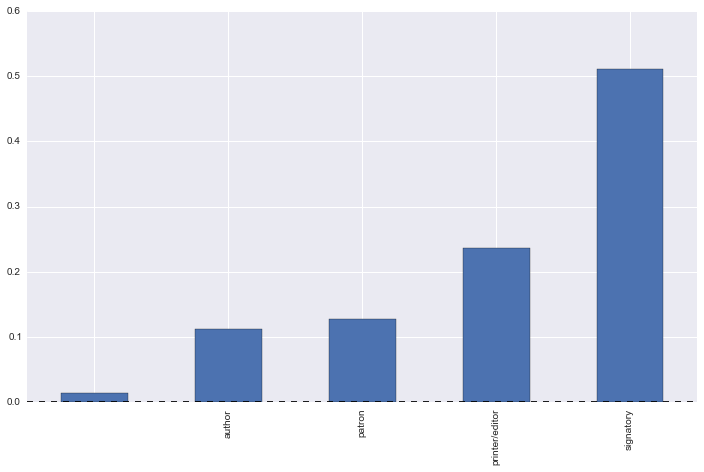

In [15]:
prob_dist(roles).plot(kind="bar")
plt.savefig("img/roles.png")

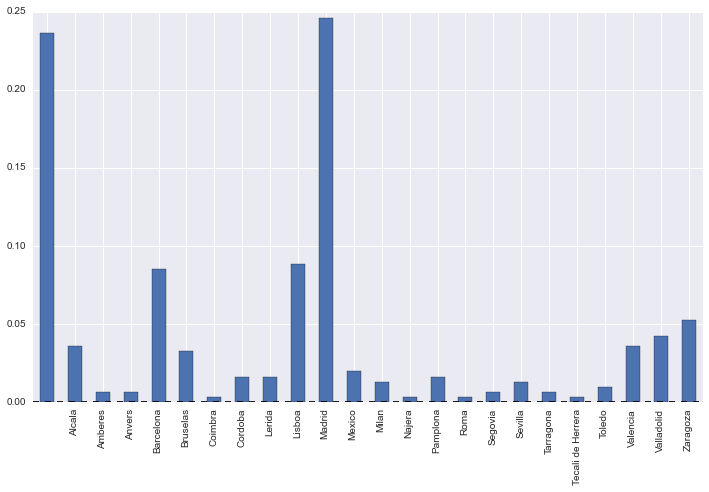

In [16]:
prob_dist(places).plot(kind="bar")
plt.savefig("img/places.png")

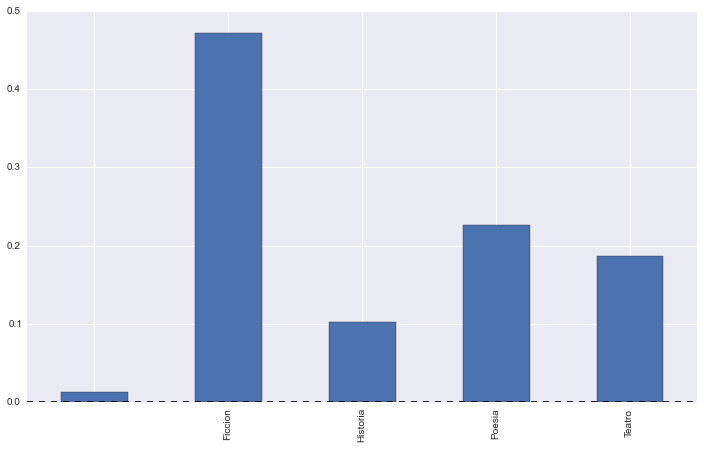

In [17]:
prob_dist(genres).plot(kind="bar")
plt.savefig("img/genres.png")

In [18]:
px.draw_simple_graph(g1)
#plt.savefig("img/china_component.png")

NameError: name 'px' is not defined

In [ ]:
px.draw_simple_graph(g2)
#plt.savefig("img/peru_component.png")

In [ ]:
print(len(g), len(g.edges()), nx.density(g))

### Centrality

In [ ]:
bc = nx.betweenness_centrality(g, weight="weight")
ec = nx.eigenvector_centrality(g, weight="weight", max_iter=500)
cc = nx.closeness_centrality(g)
deg = nx.degree(g)
pr = nx.pagerank(g, max_iter=500, weight="weight")

In [ ]:
cent_10_df = pd.DataFrame({
    "bc": [(k, g.node[k]["label"], bc[k]) for k in sorted(bc, key=bc.get, reverse=True)[0:10]],
    "ec": [(k, g.node[k]["label"], ec[k]) for k in sorted(ec, key=ec.get, reverse=True)[0:10]],
    "cc": [(k, g.node[k]["label"], cc[k]) for k in sorted(cc, key=cc.get, reverse=True)[0:10]],
    "dc": [(k, g.node[k]["label"], deg[k]) for k in sorted(deg, key=deg.get, reverse=True)[0:10]],
    #"pr": [(k, g.node[k]["label"], pr[k]) for k in sorted(pr, key=pr.get, reverse=True)[0:10]]
})

In [ ]:
print(cent_10_df)

In [ ]:
pd.Series(deg.values()).hist()

In [ ]:
deg_prob = prob_dist(deg.values())
plt.scatter(deg_prob.index, deg_prob)
plt.savefig("img/deg_dist.png")

### Degree by role

In [ ]:
authors = pd.Series(nx.degree(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "author"]).values())
patrons = pd.Series(nx.degree(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "patron"]).values())
printers = pd.Series(nx.degree(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "printer/editor"]).values())
signatories = pd.Series(nx.degree(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "signatory"]).values())

In [ ]:
# plt.plot(authors.index, authors, color="r")
# plt.plot(patrons.index, patrons, color="b")
# plt.plot(printers.index, printers, color="y")
# plt.plot(signatories.index, signatories, color="g")
df = pd.concat([authors, patrons, printers, signatories], axis=1, keys=["author", "patron", "printer", "signatory"])
desc = df.describe()

In [ ]:
desc.to_clipboard()

In [ ]:
a = [auth for auth in df["author"] if not np.isnan(auth)]
p = [auth for auth in df["patron"] if not np.isnan(auth)]
pr = [auth for auth in df["printer"] if not np.isnan(auth)]
s= [auth for auth in df["signatory"] if not np.isnan(auth)]
sns.boxplot([a,p,pr,s], names=["author", "patron", "printer", "signatory"])

In [ ]:
authors = pd.Series(nx.betweenness_centrality(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "author"]).values())
patrons = pd.Series(nx.betweenness_centrality(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "patron"]).values())
printers = pd.Series(nx.betweenness_centrality(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "printer/editor"]).values())
signatories = pd.Series(nx.betweenness_centrality(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "signatory"]).values())

In [ ]:
df = pd.concat([authors, patrons, printers, signatories], axis=1, keys=["author", "patron", "printer", "signatory"])
desc = df.describe()

In [ ]:
a = [auth for auth in df["author"] if not np.isnan(auth)]
p = [auth for auth in df["patron"] if not np.isnan(auth)]
pr = [auth for auth in df["printer"] if not np.isnan(auth)]
s= [auth for auth in df["signatory"] if not np.isnan(auth)]
sns.boxplot([a,p,pr,s], names=["author", "patron", "printer", "signatory"])

In [ ]:
g.nodes(data=True)

In [ ]:
cent_df = pd.DataFrame({
    "dc": nx.degree_centrality(g).values(),    
    "bc": bc.values(),
    "cc": cc.values(),
    "ec": ec.values(),
})

In [ ]:
cent_df.hist(bins=20)

In [ ]:
pd.Series(bc.values()).hist()

In [ ]:
pd.Series(cc.values()).hist()

In [ ]:
pd.Series(ec.values()).hist()

In [ ]:
pd.Series(pr.values()).hist()

### Assortativity

#### Degree

In [ ]:
nx.degree_assortativity_coefficient(g)

In [ ]:
r = nx.degree_assortativity_coefficient(g)
print("%3.1f"%r)

In [ ]:
nodes_by_deg = sorted(deg, key=deg.get, reverse=True)
mtrx = nx.to_numpy_matrix(g, nodelist=nodes_by_deg)
sns.heatmap(mtrx)

In [ ]:
weight_sr = pd.Series([attrs["weight"] for s, t, attrs in g.edges(data=True)])
weight_sr.describe()

In [ ]:
quant = weight_sr.quantile(.75)

In [ ]:
plt.rcParams['figure.figsize'] = (17, 12)

In [ ]:
heatmap = plt.imshow(mtrx)
heatmap.set_clim(0.0, quant)
plt.colorbar()

In [ ]:
stripmtrx = mtrx[:, :100]

In [ ]:
heatmap = plt.imshow(stripmtrx)
heatmap.set_clim(0.0, quant)
plt.colorbar()

In [ ]:
zoommtrx = nx.to_numpy_matrix(g, nodelist=nodes_by_deg)[:50, :50]
sns.heatmap(zoommtrx)

In [ ]:
zoomquant = pd.Series(zoommtrx.flatten().tolist()[0]).quantile(0.9)

In [ ]:
# heatmap = plt.imshow(zoommtrx)
# heatmap.set_clim(0.0, zoomquant)
# plt.colorbar()

#### Attribute

In [ ]:
nx.attribute_assortativity_coefficient(g, "top_place")

In [ ]:
nx.attribute_assortativity_coefficient(g, "top_genre")

In [ ]:
nx.attribute_assortativity_coefficient(g, "role")

In [ ]:
len(g.edges())

In [ ]:
def edge_types(g):
    tps = {}
    for s, t, attrs in g.edges(data=True):
        srole = g.node[s].get("role", "")
        trole = g.node[t].get("role", "")
        if srole and trole:
            if (trole, srole) in tps:
                tps[(trole, srole)].append(attrs["weight"])
            else:
                tps.setdefault((srole, trole), [])
                tps[(srole, trole)].append(attrs["weight"])
    return tps

def edge_aggs(tps):
    aggs = {}
    for k, v in tps.items():
        aggs[k] = (len(v) / 2174.0, sum(v) / len(v))
    return aggs

In [ ]:
etps = edge_types(g)
aggs = edge_aggs(etps)

In [ ]:
aggs

In [ ]:
2174 * 0.025

In [ ]:
pd.Series(etps[(u'patron', u'author')]).plot(kind="box")

### Clustering

In [ ]:
nx.average_clustering(g)

In [ ]:
pd.Series(nx.clustering(g).values()).hist()

In [ ]:
nx.transitivity(g)

### Paths

In [ ]:
nx.diameter(g)

In [ ]:
nx.average_shortest_path_length(g)